In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy import signal
from scipy import special
from cloud_detection import detect_cloud_edge, refine_cloud_detection, find_cloud_mask

In [2]:
path_testl2 = '/home/bia/euliaa_postproc/data/L2Test_NC_for_Aprofiles.nc'
ds = xr.open_dataset(path_testl2)

In [3]:
cloud_base = detect_cloud_edge(ds.attenuated_backscatter_0, ds.altitude, return_height = False, vg_thres=.25)
cloud_top = detect_cloud_edge(ds.attenuated_backscatter_0, ds.altitude, return_height = False, base_or_top='top',vg_thres=.5)
time_array = np.repeat(ds.time.values.reshape(-1,1),809)


for i in range(len(ds.time)):
    cb = cloud_base[i]
    ct = cloud_top[i]
    bsc = ds.attenuated_backscatter_0.isel(time=i)
    refine_cloud_detection(bsc,cb,ct)#,vg_thres=0.2)

cloud_base[:,:6] = 0 # the lowest gates are not valid
cloud_top[:,:6] = 0

ds['cloud_mask'], ds['below_cloud_top'], ds['above_cloud_base'] = find_cloud_mask(ds.attenuated_backscatter_0,cloud_base,cloud_top,
                                    return_below_cloud_top=True, return_above_cloud_base=True)

# ds['below_cloud_top']
cloud_base_height = ds.altitude.values[1:-1]*np.where(cloud_base,1,np.nan)
cloud_top_height = ds.altitude.values[1:-1]*np.where(cloud_top,1,np.nan)


/home/bia/acbr/.venv/lib/python3.10/site-packages/xarray/core/computation.py:818: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/home/bia/euliaa_postproc/tests/cloud_detection.py:120: RuntimeWarning: All-NaN slice encountered
  if np.nanmax(y[1:-1])<vg_thres: # max gradient below threshold, no satisfactory cloud top
/home/bia/euliaa_postproc/tests/cloud_detection.py:126: RuntimeWarning: All-NaN slice encountered
  cti[1:-1] = np.where((y[1:-1]==np.nanmax(y[1:-1])), 1, 0)[::-1]


In [ ]:
# below_cloud_top = np.zeros_like(ds.attenuated_backscatter_0)
# above_cloud_top = np.zeros_like(ds.attenuated_backscatter_0)
# below_cloud_base = np.zeros_like(ds.attenuated_backscatter_0)
# above_cloud_base = np.zeros_like(ds.attenuated_backscatter_0)
# below_cloud_base[:,1:-1] = np.cumsum(cloud_base[:,::-1],axis=1)[:,::-1]
# above_cloud_base[:,1:-1] = np.cumsum(cloud_base,axis=1)#[:,::-1]
# below_cloud_top[:,1:-1] = np.cumsum(cloud_top[:,::-1],axis=1)[:,::-1]
# above_cloud_top[:,1:-1] = np.cumsum(cloud_top,axis=1)
# below_cloud_top[:,0] = below_cloud_top[:,1]
# below_cloud_base[:,0] = below_cloud_base[:,1]
# above_cloud_base[:,-1] = above_cloud_base[:,-2]
# above_cloud_top[:,-1] = above_cloud_top[:,-2]
# n_above_cloud_top = np.cumsum(above_cloud_top,axis=1)
# n_above_cloud_base = np.cumsum(above_cloud_base,axis=1)

# ds['cloud_mask'] = (('time','altitude'),
#                     find_cloud_mask(ds.attenuated_backscatter_0,cloud_base,cloud_top))

ds['cloud_mask'] = find_cloud_mask(ds.attenuated_backscatter_0,cloud_base,cloud_top)

# ds['cloud_mask'] = xr.DataArray(((above_cloud_base>0) & (below_cloud_top>0) & ~((above_cloud_top>0) & (below_cloud_base>0) & (n_above_cloud_base>n_above_cloud_top))),
#                            dims=('time', 'altitude'))

# cloud_mask = xr.DataArray(((above_cloud_base>0) & (below_cloud_top>0)) & ~((above_cloud_top>0) & (below_cloud_base>0)),
#                            dims=('time', 'altitude'))


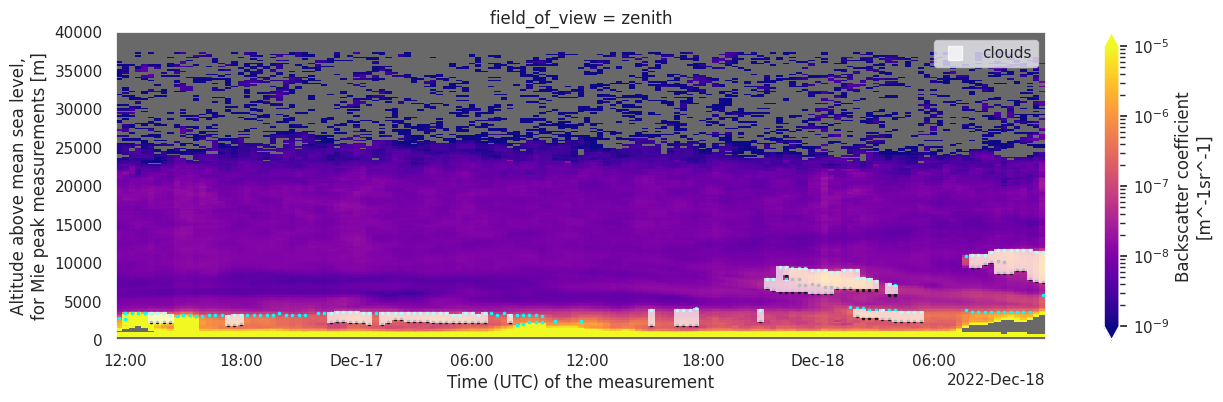

In [5]:
fig,ax = plt.subplots(figsize = (15,4))
im=ds.attenuated_backscatter_0.plot(x='time',vmin=1e-9,vmax=1e-5,norm=colors.LogNorm(),cmap='plasma')
ax.scatter(time_array, cloud_base_height,s=10,color='k',marker='.')
ax.scatter(time_array, cloud_top_height,s=10,color='cyan',marker='.')

# im=plt.pcolormesh(ds.time, ds.altitude, cloud_mask.T)#((cloud_mask2>0) & (cloud_mask>0)).T)
ax.set_ylim(0,30000)
# plt.colorbar(im)
ax.set_facecolor('dimgray')
# cloud_mask[cloud_mask==0] = np.nan
ds['cloud_mask']=ds.cloud_mask.where(ds.cloud_mask,np.nan)
ds.cloud_mask.T.plot(alpha=.7,vmin=0, vmax=1, cmap='Greys_r',ylim=(0,40000),add_colorbar=False)
ax.plot([],[],lw=0,marker='s', ms=10, color='white', alpha=.7, label='clouds')
ax.legend(loc='upper right')

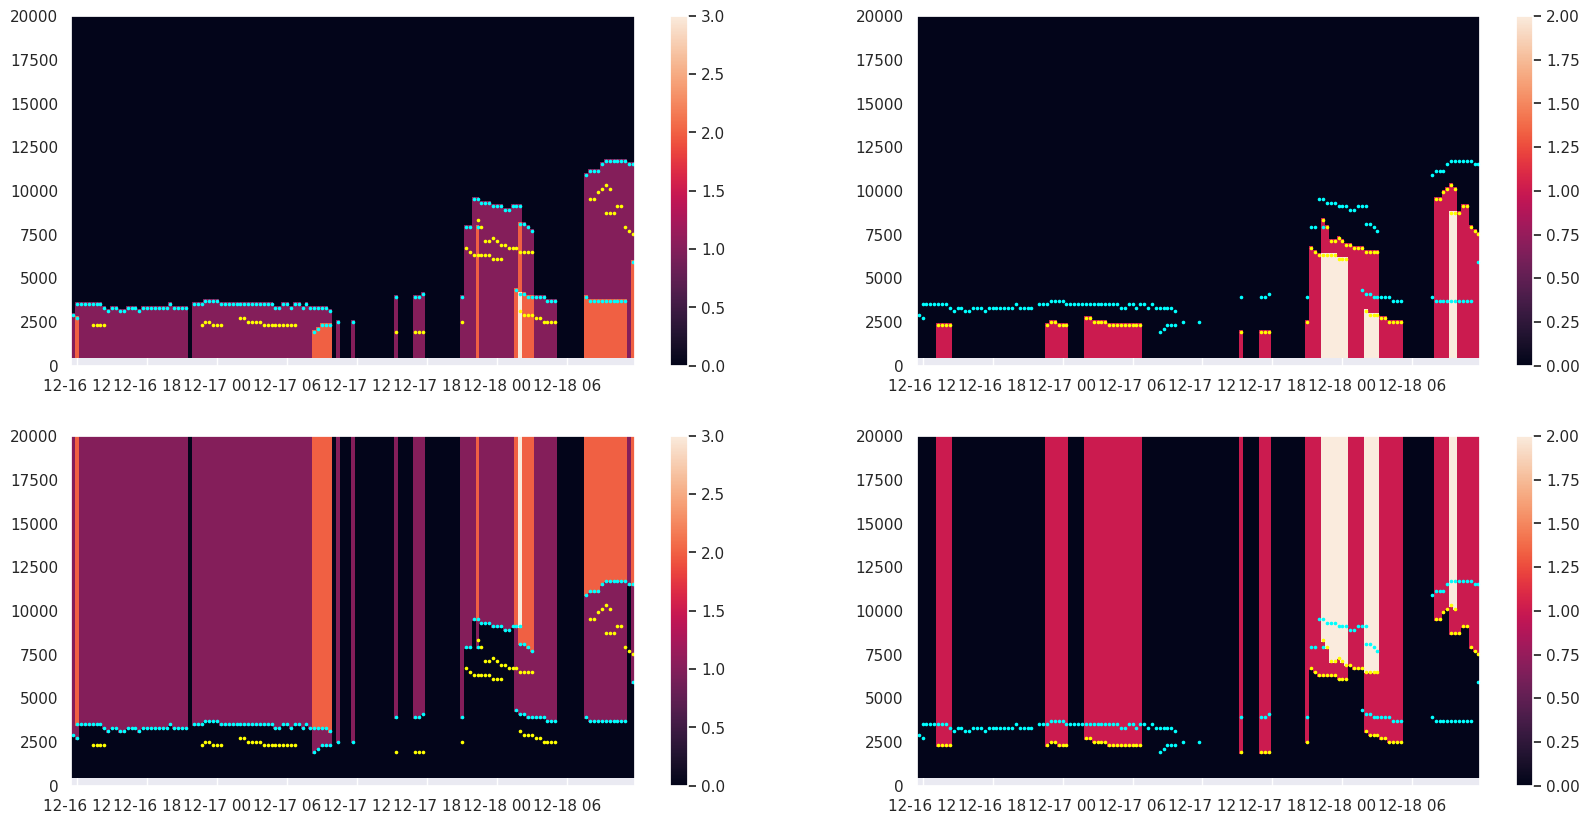

In [8]:
fig,axs = plt.subplots(2,2,figsize=(20,10))
im=axs[0,0].pcolormesh(ds.time,ds.altitude,below_cloud_top.T)#,vmin=0,vmax=2)#,cmap='')
im2 = axs[0,1].pcolormesh(ds.time,ds.altitude,below_cloud_base.T)#,vmin=0,vmax=2)#,cmap='')
im3=axs[1,0].pcolormesh(ds.time,ds.altitude,above_cloud_top.T)#,vmin=0,vmax=2)#,cmap='')
im4=axs[1,1].pcolormesh(ds.time,ds.altitude,above_cloud_base.T)#,vmin=0,vmax=2)#,cmap='')
for ax in axs.flatten():
    ax.scatter(time_array, cloud_top_height,s=10,color='cyan',marker='.')
    ax.scatter(time_array, cloud_base_height,s=10,color='yellow',marker='.')
    ax.set_ylim(0,20000)
# plt.xlim(ds.time[-20],ds.time[-1])
plt.colorbar(im,ax=axs[0,0])
plt.colorbar(im2,ax=axs[0,1])
plt.colorbar(im3,ax=axs[1,0])
plt.colorbar(im4,ax=axs[1,1])

In [14]:

n_above_cloud_top = np.cumsum(above_cloud_top,axis=1)
n_above_cloud_base = np.cumsum(above_cloud_base,axis=1)

ds['cloud_mask'] = (('time','altitude'),
                    ((above_cloud_base>0) & (below_cloud_top>0)) & ~((above_cloud_top>0) & (below_cloud_base>0) & (n_above_cloud_base>n_above_cloud_top)),
                    )


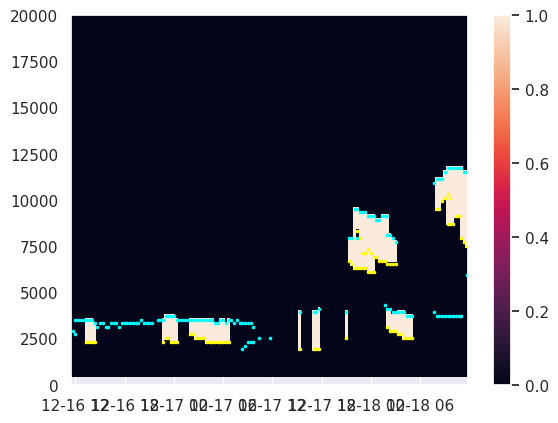

In [16]:
im=plt.pcolormesh(ds.time, ds.altitude, ds.cloud_mask.T)#((cloud_mask2>0) & (cloud_mask>0)).T)
# plt.pcolormesh(ds.time, ds.altitude, cloud_top_height2.T)
plt.ylim(0,20000)
plt.scatter(time_array, cloud_top_height,s=10,color='cyan',marker='.')
plt.scatter(time_array, cloud_base_height,s=10,color='yellow',marker='.')
plt.colorbar()#im)


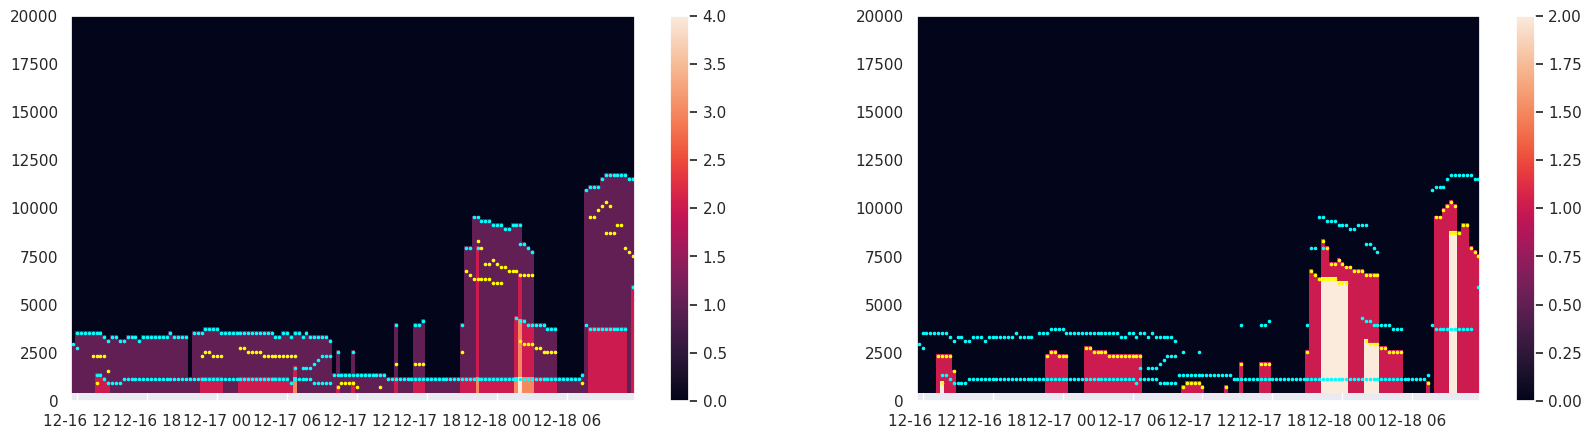

In [156]:
cloud_mask2[(cloud_mask2>1) & (cloud_mask1<1)] = 1

fig,axs = plt.subplots(1,2,figsize=(20,5))
im=axs[0].pcolormesh(ds.time,ds.altitude,cloud_mask2.T)#,vmin=0,vmax=2)#,cmap='')
im2 = axs[1].pcolormesh(ds.time,ds.altitude,cloud_mask1.T)#,vmin=0,vmax=2)#,cmap='')
for ax in axs:
    ax.scatter(time_array, cloud_top_height,s=10,color='cyan',marker='.')
    ax.scatter(time_array, cloud_base_height,s=10,color='yellow',marker='.')
    ax.set_ylim(0,20000)
# plt.xlim(ds.time[-20],ds.time[-1])
plt.colorbar(im,ax=axs[0])
plt.colorbar(im2,ax=axs[1])

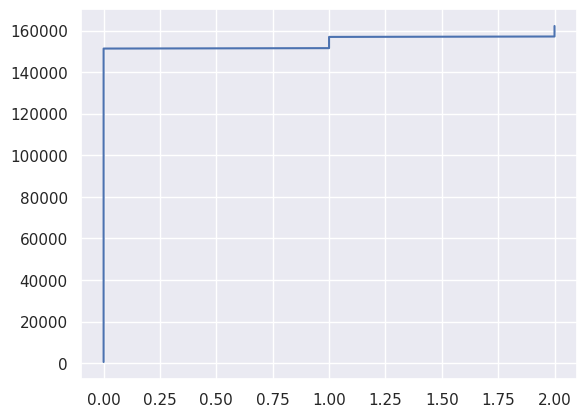

In [34]:
plt.plot(cloud_mask.isel(time=-1),ds.altitude)

In [12]:
cloud_mask.shape

(145, 811)

In [ ]:
# for i in range(len(ds.time)):
#     cb = cloud_base[i]
#     ct = cloud_top[i]
#     bsc = ds.attenuated_backscatter_0.isel(time=i)
#     icb = np.where(cb)[0]

#     if len(icb)==0:
#         print(i, 'aa')
#         continue

#     for i_icb, ii in enumerate(icb):
#         ict = np.where(ct)[0]

#         if (((i_icb == len(icb)-1) and (np.any(ict>ii))) |
#             ((i_icb < len(icb)-1) and (np.any((ict > ii) & (ict < icb[i_icb+1]))))):
#             # print('Already a cloud top', np.where(ct[-1])[0],ii)
#             continue

#         elif (i_icb < len(icb)-1): # if several cloud layers
#             x = np.log(bsc[ii:icb[i_icb+1]])
#             alt = ds.altitude[ii:icb[i_icb+1]]
#             cti = ct[ii:icb[i_icb+1]]
#         else:
#             x = np.log(bsc[ii:])
#             alt = ds.altitude[ii:]
#             cti = ct[ii:]

#         F = 5 if len(x)>5 else len(x)
#         K = 3 if len(x)>5 else len(x)-1
#         xf, y = savgol(x[::-1], F, K)

#         # Set y to nan where cloud top conditions are not matched
#         y[1:-1][xf[2:]<np.log(1e-8)] = np.nan # abs threshold on backscatter
#         y[1:-1][~((y[2:]-y[1:-1]<0) & (y[:-2]-y[1:-1]<0))] = np.nan # sign threshold on gradient

#         if np.nanmax(y[1:-1])<0.1:
#             cb[ii] = 0 # no cloud top detected, removing cloud base
#             print('no cloud top detected, removing cloud base', ds.time[i].values, ds.altitude[ii].item())

#         else:
#             try:
#                 cti[1:-1] = np.where((y[1:-1]==np.nanmax(y[1:-1])), 1, 0)[::-1]
#             except:
#                 cti[:] = np.where((y[1:-1]==np.nanmax(y[1:-1])), 1, 0)[::-1]


0 aa
1 aa
2 aa
3 aa
4 aa
10 aa
11 aa
12 aa
13 aa
14 aa
15 aa
16 aa
17 aa
18 aa
19 aa
20 aa
21 aa
22 aa
23 aa
24 aa
25 aa
26 aa
27 aa
28 aa
29 aa
30 aa
31 aa
32 aa
39 aa
40 aa
41 aa
42 aa
58 aa
59 aa
60 aa
61 aa
62 aa
63 aa
64 aa
65 aa
66 aa
67 aa
74 aa
75 aa
76 aa
77 aa
78 aa
80 aa
81 aa
82 aa
84 aa
85 aa
86 aa
87 aa
91 aa
92 aa
93 aa
94 aa
95 aa
96 aa
97 aa
98 aa
99 aa
125 aa
126 aa
127 aa
128 aa
129 aa
130 aa
132 aa


/tmp/ipykernel_13617/1595681387.py:36: RuntimeWarning: All-NaN slice encountered
  if np.nanmax(y[1:-1])<0.1:
/tmp/ipykernel_13617/1595681387.py:42: RuntimeWarning: All-NaN slice encountered
  cti[1:-1] = np.where((y[1:-1]==np.nanmax(y[1:-1])), 1, 0)[::-1]


(0.0, 40000.0)

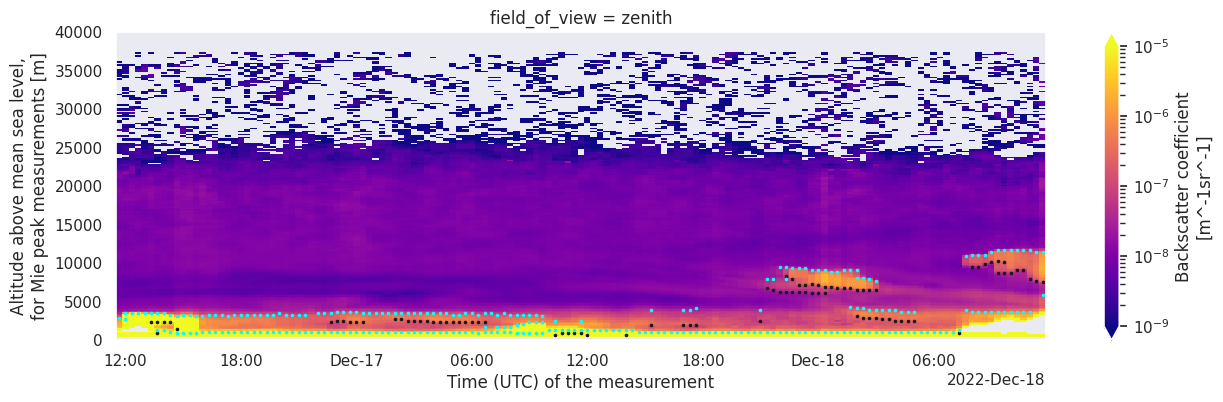